# CE-40717: Machine Learning

## Amirhossein Kargaran Khouzani std.no: 99201119

## HW8-Clustering & Reinforcement Learning

### Kmeans & GMM:

At this question, we tend to implement Kmeans & GMM algorithms. For this purpose, `DO NOT EMPLOY` ready-for-use python libraries. Use this implementation for solving the following questions. Kmeans should continue till centeroids won't change. Furthermore, GMM also should continue till the difference of two consecutive likelihood logarithm would be less than 0.1. Notice that after executing the Kmeans part, the primitive centroids of GMM should be identical with ultimate Kmeans centroids.

In [2]:
# In the latest versions of scikit-learn, there is no module sklearn.datasets.samples_generator
from sklearn.datasets import make_classification, make_moons, make_circles
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


#### Part 1:

Utilize the subsequent cell in order to create the Dataset. Afterwards, try to execute the algorithm with k=2 centroids. At Kmeans, it is recommended to execute the algorithm with several various starting states in order to eventually choose the best respective result.

In [3]:
X,Y = make_classification(n_samples=700, n_features=10, n_informative=5,
                          n_redundant=0, n_clusters_per_class=2, n_classes=3)

In [4]:
X.shape

(700, 10)

## kmeans
In this Kmeans should continue till centeroids won't change.

In [5]:
def kmeans_scratch(dataset, k):
    
    # shuffle data and randomly select k elements as centroids
    centroids = dataset.copy()
    np.random.shuffle(centroids)
    centroids = centroids[:k]
    
    # create empty list to store centroids
    list_centroids = []

    # for to inf
    while True:
        # assign each point to nearest centroid using euclidean distance measure
        distances = np.sqrt(((dataset - centroids.reshape(k,1,centroids.shape[1]))**2).sum(axis=2))
        c_set = np.argmin(distances, axis=0)
        # update centroids
        centroids = np.array([dataset[c_set==i].mean(axis=0) for i in range(k)])

        # save if want to make an animation plot
        list_centroids.append(centroids)
        
        # break if centroids dont change
        if len(list_centroids)>2:
            if all(i in list_centroids[-1] for i in list_centroids[-2]):
                break
    return centroids, c_set

In [6]:
centroids, clusters = kmeans_scratch(dataset=X, k=2)

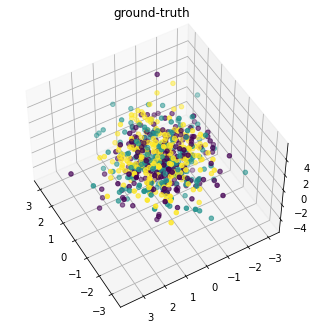

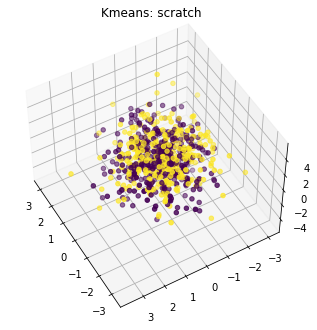

In [7]:
figures = {1: 'ground-truth', 2:'Kmeans: scratch'}
labels_dict = {1: Y, 2:clusters}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = labels_dict[n].astype(float))
    if n == 2:
        # black centroids with bigger point sizes 
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s = 200, c='black')
    ax.set_title(figures[n])


## GMM
For just this part (only implementation of GMM) i used this [source](https://github.com/Rajsuryan-Singh/clustering_from_scratch/blob/main/gaussian_mixture.py).
- the primitive centroids of GMM is not identical with ultimate Kmeans centroids
- this code used max itteration instead of threshold termination

In [8]:
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape

        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)
    
    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(
                mean=self.mu[i], 
                cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)


In [9]:
GMM_model = GMM(k = 2, max_iter=1000)
GMM_model.fit(X)
Gmm_Y = GMM_model.predict(X)

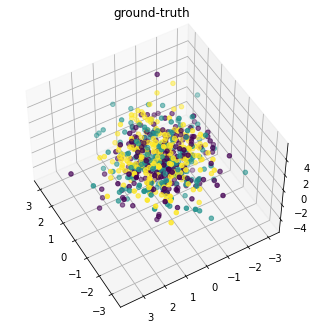

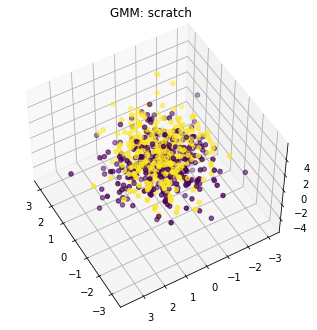

In [10]:
figures = {1: 'ground-truth', 2:'GMM: scratch'}
labels_dict = {1: Y, 2:Gmm_Y}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = labels_dict[n].astype(float))
    ax.set_title(figures[n])


#### Part 2:

In a separated cell, implement `Purity` and `Rand-Index` criteria in order to compare the performance of mentioned algorithms.

In [11]:
def Rand_Index(Y, clusters):
    M0, M1, M2, M3 = 0, 0, 0, 0
    for i in range(len(Y)):
        for j in range(i):
            # diffrent cases 
            if Y[i] != Y[j] and clusters[i] != clusters[j]:
                M0 += 1
            elif Y[i] != Y[j] and clusters[i] == clusters[j]:
                M1 += 1
            elif Y[i] == Y[j] and clusters[i] != clusters[j]:
                M2 += 1
            else:
                M3 += 1
    return np.float(M0+M3)/(M0+M1+M2+M3)

def Purity(Y, clusters):
    C = len(np.unique(Y))
    K = len(np.unique(clusters))
    
    prob_ij = np.zeros((K, C))
    Temp_i = np.zeros((K, 1))
    for k in range(K):
        Temp_i[k] = (clusters == k).sum()
        Y_cluster_k = Y[clusters == k]
        for c in range(C):
            Temp_ij = (Y_cluster_k == c).sum()
            prob_ij[k, c] = Temp_ij/Temp_i[k]
    return (prob_ij.max(axis=1)).sum() / K

In [12]:
# Kmeans
possible_matching = [Y, ~Y+2, Y+1, ~Y+3]

rand_kmeans = 0
for i in possible_matching:
    rand_kmeans = max(rand_kmeans, Rand_Index(i, clusters))
    
    
purity_kmeans = 0
for i in possible_matching:
    purity_kmeans = max(purity_kmeans, Purity(i, clusters))
    
print(f"Rand_Index for kmeans: {rand_kmeans}")
print(f"Purity for kmeans: {purity_kmeans}")

Rand_Index for kmeans: 0.520453709380748
Purity for kmeans: 0.4372680890538033


In [13]:
# GMM 
possible_matching = [Y, ~Y+2, Y+1, ~Y+3]

rand_gmm = 0
for i in possible_matching:
    rand_gmm = max(rand_gmm, Rand_Index(i, Gmm_Y))
    
    
purity_gmm = 0
for i in possible_matching:
    purity_gmm = max(purity_gmm, Purity(i, Gmm_Y))
    
print(f"Rand_Index for GMM: {rand_gmm}")
print(f"Purity for GMM: {purity_gmm}")

Rand_Index for GMM: 0.5113549969343961
Purity for GMM: 0.41207765845992667


#### Part 3:

Use the following cell in order to create new Datasets. Afterwards, try to execute mentioned algorithms on new Dataset and eventually compare the recent results with the help of visualization(there is no problem for using relevant python libraries like `matplotlib`). Consider two clusters for this part.

In [14]:
X, Y = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_classes=2)

In [15]:
X.shape

(700, 2)

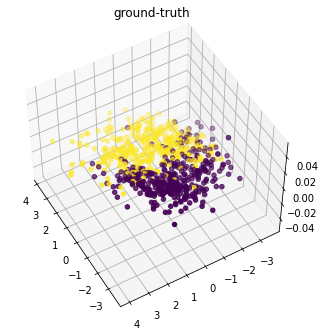

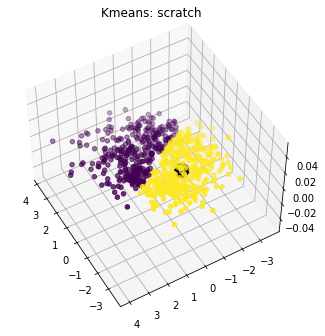

In [16]:
centroids, clusters = kmeans_scratch(dataset=X, k=2)
figures = {1: 'ground-truth', 2:'Kmeans: scratch'}
labels_dict = {1: Y, 2:clusters}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    if n == 2:
        # black centroids with bigger point sizes 
        ax.scatter(centroids[:, 0], centroids[:, 1], s = 200, c='black')
    ax.set_title(figures[n])


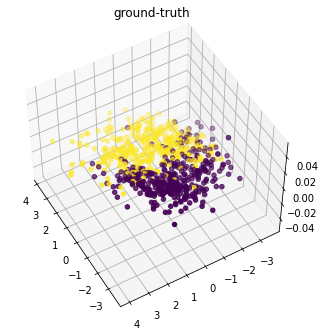

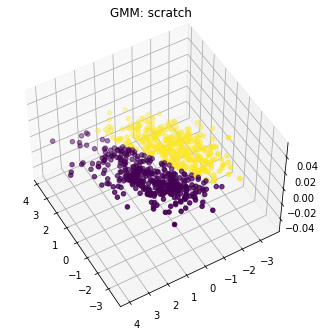

In [17]:
GMM_model = GMM(k = 2, max_iter=1000)
GMM_model.fit(X)
Gmm_Y = GMM_model.predict(X)
figures = {1: 'ground-truth', 2:'GMM: scratch'}
labels_dict = {1: Y, 2:Gmm_Y}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    ax.set_title(figures[n])


In [18]:
X, Y = make_moons(n_samples=700, noise=0.2)

In [19]:
X.shape

(700, 2)

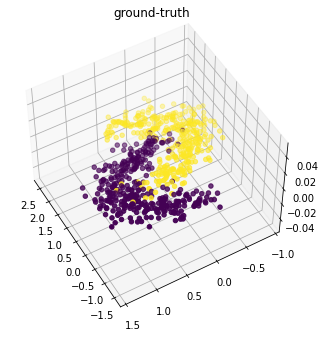

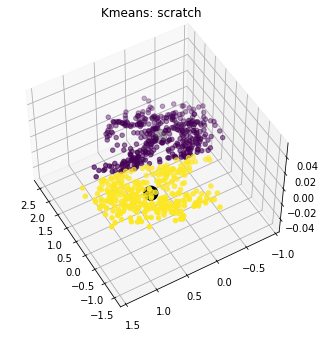

In [20]:
centroids, clusters = kmeans_scratch(dataset=X, k=2)
figures = {1: 'ground-truth', 2:'Kmeans: scratch'}
labels_dict = {1: Y, 2:clusters}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    if n == 2:
        # black centroids with bigger point sizes 
        ax.scatter(centroids[:, 0], centroids[:, 1], s = 200, c='black')
    ax.set_title(figures[n])


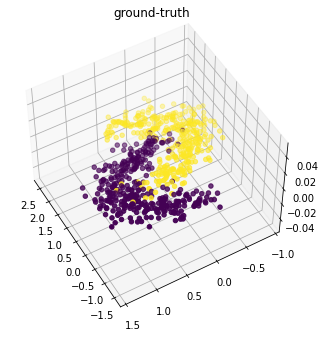

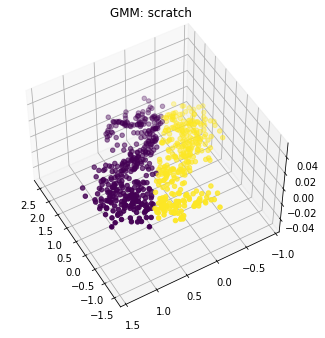

In [21]:
GMM_model = GMM(k = 2, max_iter=1000)
GMM_model.fit(X)
Gmm_Y = GMM_model.predict(X)
figures = {1: 'ground-truth', 2:'GMM: scratch'}
labels_dict = {1: Y, 2:Gmm_Y}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    ax.set_title(figures[n])


In [22]:
X, Y = make_circles(n_samples=700, noise=0.2)

In [23]:
X.shape

(700, 2)

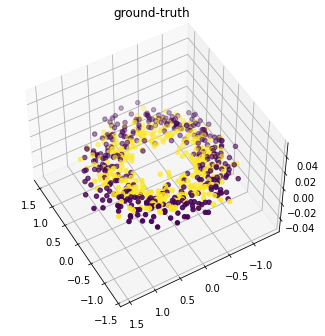

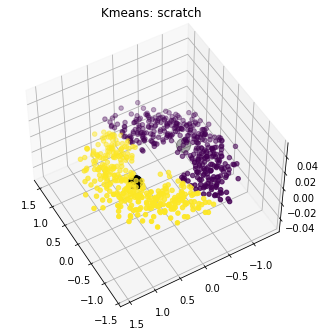

In [24]:
centroids, clusters = kmeans_scratch(dataset=X, k=2)
figures = {1: 'ground-truth', 2:'Kmeans: scratch'}
labels_dict = {1: Y, 2:clusters}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    if n == 2:
        # black centroids with bigger point sizes 
        ax.scatter(centroids[:, 0], centroids[:, 1], s = 200, c='black')
    ax.set_title(figures[n])


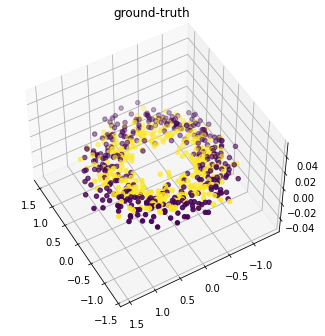

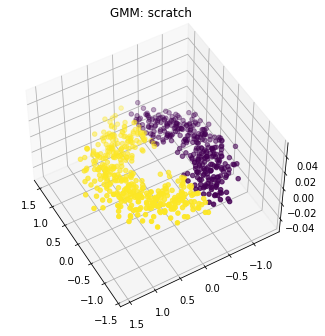

In [25]:
GMM_model = GMM(k = 2, max_iter=1000)
GMM_model.fit(X)
Gmm_Y = GMM_model.predict(X)
figures = {1: 'ground-truth', 2:'GMM: scratch'}
labels_dict = {1: Y, 2:Gmm_Y}
for n in figures.keys():
    fig = plt.figure(num = n, figsize = (4, 4))
    ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=50, azim=150)
    ax.scatter(X[:, 0], X[:, 1], c = labels_dict[n].astype(float))
    ax.set_title(figures[n])


### Reinforcement Learning:

At the bellow cell, besides the required libraries have been imported, feel free for changing the num_states variable with your desired number.

In [26]:
import numpy as np
import random
import gym

In [27]:
env = gym.make("MountainCar-v0")
num_actions = 3
num_states = [200, 20] # 200 * 20 = 4000

q_table = np.random.uniform(-2, 0, size=(num_states + [num_actions]))
policy = np.zeros(shape=(num_states))

# You may change the inputs of any function as you desire.

[2021-07-09 21:12:12,216] Making new env: MountainCar-v0


#### Part 1:

Next cell wants you supplement two functions. First for transforming the continuous space into discrete one (in order to make using q_table feasible), second for updating q_values based on the last action done by agent.

In [28]:
# This is just one example of a discretization function. You can change it as you want.
def discretize_state(x, minn, step):
    return int((x - minn) / step)


def env_state_to_Q_state(state):
    """
    Your code here.
    return value: [int]
    hint: use discretize_state func here for both of p and v and combine them somehow to reach an int.
    """
    [position, velocity] = state
    discrete_state_position = discretize_state(position, -1.2, (0.6 + 1.2) / num_states[0])
    discrete_state_velocity = discretize_state(velocity, -0.07, (0.07 + 0.07) / num_states[1])
    return discrete_state_position, discrete_state_velocity


def update_q(state):
    """Your code here."""
    return np.max(q_table[state])

#### Part 2:

At the following cell, the ends of two functions are getting current action based on the policy and defining the training process respectively.

In [29]:
# You may change the inputs of any function as you desire.
def get_action(discrete_state):
    """Your code here."""
    action = np.argmax(q_table[discrete_state])
    return action 


def q_learning(q, reward, discrete_state):
    """Your code here."""
    learning_rate = 0.2
    gamma = 0.9
    q = (1 - learning_rate) * q + learning_rate * (reward + gamma * update_q(discrete_state))
    return q

def save_policy():
    """Save your optimal policy to a file with name policy.npy"""
    for episode in range(5000):        

        discrete_state, score, done, step = env_state_to_Q_state(env.reset()), 0, False, 0

        while not done:
            action = get_action(discrete_state)
            policy[discrete_state] = int(action)
            state, reward, done, _ = env.step(action)
            q = q_table[discrete_state + (action,)]
            discrete_state2 = env_state_to_Q_state(state)
            q2 = q_learning(q, reward, discrete_state2)
            q_table[discrete_state + (action,)] = q2 if not done else q

            step += 1
            
            if done and state[0] >= 0.5:
                q_table[discrete_state + (action,)] = 0
                np.save('policy.npy', policy)
                return state[0], step
            
            discrete_state = discrete_state2


In [30]:
position, step = save_policy()
print(f"at step {step} the position is {position}")

at step 184 the position is 0.5092310767606116


#### Part 3:

Ultimately, the score function examines the average performance of Agent (after nearly 1000 times) based on previous implementations.

In [31]:
# Attention: don't change this function. we will use this to grade your policy which you will hand in with policy.npy
# btw you can use it to see how you are performing. Uncomment two lines which are commented to be able to see what is happening visually.
def score():
    policy, scores = np.load("policy.npy"), []
    print(policy)
    for episode in range(1000):
        print(f"******Episode {episode}")
        state, score, done, step = env_state_to_Q_state(env.reset()), 0, False, 0
        while not done:
            # time.sleep(0.04)
            action = int(policy[state])
            state, reward, done, _ = env.step(action)
            state = env_state_to_Q_state(state)
            step += 1
            score += int(reward)
            # env.render()
        print(f"Score:{score}")
        scores.append(score)
    print(f"Average score over 1000 run : {np.array(scores).mean()}")

score()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
******Episode 0
Score:-200
******Episode 1
Score:-200
******Episode 2
Score:-200
******Episode 3
Score:-200
******Episode 4
Score:-200
******Episode 5
Score:-200
******Episode 6
Score:-200
******Episode 7
Score:-200
******Episode 8
Score:-200
******Episode 9
Score:-200
******Episode 10
Score:-200
******Episode 11
Score:-200
******Episode 12
Score:-200
******Episode 13
Score:-200
******Episode 14
Score:-200
******Episode 15
Score:-200
******Episode 16
Score:-200
******Episode 17
Score:-200
******Episode 18
Score:-200
******Episode 19
Score:-200
******Episode 20
Score:-200
******Episode 21
Score:-200
******Episode 22
Score:-200
******Episode 23
Score:-200
******Episode 24
Score:-200
******Episode 25
Score:-200
******Episode 26
Score:-200
******Episode 27
Score:-200
******Episode 28
Score:-200
******Episode 29
Score:-200
******Episode 

Score:-200
******Episode 281
Score:-200
******Episode 282
Score:-200
******Episode 283
Score:-200
******Episode 284
Score:-200
******Episode 285
Score:-200
******Episode 286
Score:-200
******Episode 287
Score:-200
******Episode 288
Score:-200
******Episode 289
Score:-200
******Episode 290
Score:-200
******Episode 291
Score:-200
******Episode 292
Score:-200
******Episode 293
Score:-200
******Episode 294
Score:-200
******Episode 295
Score:-200
******Episode 296
Score:-200
******Episode 297
Score:-200
******Episode 298
Score:-200
******Episode 299
Score:-200
******Episode 300
Score:-200
******Episode 301
Score:-200
******Episode 302
Score:-200
******Episode 303
Score:-200
******Episode 304
Score:-200
******Episode 305
Score:-200
******Episode 306
Score:-200
******Episode 307
Score:-200
******Episode 308
Score:-200
******Episode 309
Score:-200
******Episode 310
Score:-200
******Episode 311
Score:-200
******Episode 312
Score:-200
******Episode 313
Score:-200
******Episode 314
Score:-200
***

******Episode 563
Score:-200
******Episode 564
Score:-200
******Episode 565
Score:-200
******Episode 566
Score:-200
******Episode 567
Score:-200
******Episode 568
Score:-200
******Episode 569
Score:-200
******Episode 570
Score:-200
******Episode 571
Score:-200
******Episode 572
Score:-200
******Episode 573
Score:-200
******Episode 574
Score:-200
******Episode 575
Score:-200
******Episode 576
Score:-200
******Episode 577
Score:-200
******Episode 578
Score:-200
******Episode 579
Score:-200
******Episode 580
Score:-200
******Episode 581
Score:-200
******Episode 582
Score:-200
******Episode 583
Score:-200
******Episode 584
Score:-200
******Episode 585
Score:-200
******Episode 586
Score:-200
******Episode 587
Score:-200
******Episode 588
Score:-200
******Episode 589
Score:-200
******Episode 590
Score:-200
******Episode 591
Score:-200
******Episode 592
Score:-200
******Episode 593
Score:-200
******Episode 594
Score:-200
******Episode 595
Score:-200
******Episode 596
Score:-200
******Episode 

******Episode 845
Score:-200
******Episode 846
Score:-200
******Episode 847
Score:-200
******Episode 848
Score:-200
******Episode 849
Score:-200
******Episode 850
Score:-200
******Episode 851
Score:-200
******Episode 852
Score:-200
******Episode 853
Score:-200
******Episode 854
Score:-200
******Episode 855
Score:-200
******Episode 856
Score:-200
******Episode 857
Score:-200
******Episode 858
Score:-200
******Episode 859
Score:-200
******Episode 860
Score:-200
******Episode 861
Score:-200
******Episode 862
Score:-200
******Episode 863
Score:-200
******Episode 864
Score:-200
******Episode 865
Score:-200
******Episode 866
Score:-200
******Episode 867
Score:-200
******Episode 868
Score:-200
******Episode 869
Score:-200
******Episode 870
Score:-200
******Episode 871
Score:-200
******Episode 872
Score:-200
******Episode 873
Score:-200
******Episode 874
Score:-200
******Episode 875
Score:-200
******Episode 876
Score:-200
******Episode 877
Score:-200
******Episode 878
Score:-200
******Episode 